# Feature-Aware Data Augmentation

Augmentation policies to consider:
- Simple policy randomly sampling of n transforms 
- Constrained sampling policy with a blacklist of transforms to avoid 
- Feature-aware augmentation policy where transforms are picked based on their (transform, feature) behavior

In [1]:
# data
import os
import pickle
import glob
import numpy as np
from tqdm.notebook import tqdm
from datasets import Dataset, load_dataset, load_from_disk, concatenate_datasets
from datasets.utils.logging import disable_progress_bar

# amrs
import amrlib
import penman

# transform
import sibyl
import time
import torch
import inspect
import random
from functools import partial

# eval pipeline
import pandas as pd
from transformers import pipeline
from huggingface_hub import HfApi, ModelFilter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.special import softmax

# train pipeline
import shutil
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback
)

# cleanlab pipeline
from cleanlab.filter import find_label_issues
from cleanlab.rank import get_label_quality_scores

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sleev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sleev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import evaluate
evaluate.utils.logging.disable_progress_bar() 
evaluate.utils.logging.set_verbosity_error()

import transformers
transformers.utils.logging.disable_progress_bar() 
transformers.utils.logging.set_verbosity_error()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.use_deterministic_algorithms(False)
disable_progress_bar()

In [162]:
# helper functions

def normalize_minmax(df):
    return_np = False
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
        return_np = True
    for column in df.columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min()) 
    if return_np:
        return df.to_numpy()
    return df

def normalize_sum(df):
    return_np = False
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
        return_np = True
    for column in df.columns:
        df[column] = df[column] / df[column].sum()
    if return_np:
        return df.to_numpy()
    return df

def augment_data(batch, transform, keep_originals=True):
    new_texts, new_labels = [], []
    for text, label in zip(batch['text'], batch['label']):
        new_text, new_label = transform.apply([text], [label])
        new_texts.extend(new_text)
        new_labels.extend(new_label)
    if keep_originals:
        return {"text": batch['text'] + new_texts, "label": batch['label'] + new_labels}
    else:
        return {"text": new_texts, "label": new_labels}
    
def percent_dataset_changed(d1, d2):
    return sum([t1['text'] != t2['text'] for t1, t2 in zip(d1, d2)]) / len(d1) 

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy_score(labels, predictions.argmax(-1))
    precision, recall, fbeta_score, support = precision_recall_fscore_support(
        y_true=labels, 
        y_pred=predictions.argmax(-1), 
        average="weighted", 
        zero_division=0)
    return { 'accuracy': acc , 
             'precision': precision, 
             'recall': recall, 
             'fbeta_score': fbeta_score} 

def compute_accuracy(predictions, labels):
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    if len(labels.shape) > 1:
        acc = acc_at_k(labels, predictions, k=2)       
    else:
        acc = accuracy_score(labels, np.argmax(predictions, -1))
    return acc

def vectorize(output):
    sorted_output = sorted(output, key=lambda d: d['label']) 
    probs = torch.tensor([d['score'] for d in sorted_output])
    return probs

def sample_transforms(transforms, p, n=2, replace=False):
    return np.random.choice(transforms, size=n, p=p, replace=replace).tolist()

def transforms_to_ids(sampled_transforms, all_transforms):
    transforms_ids = [all_transforms.index(i) for i in sampled_transforms]
    transforms_applied = np.zeros(len(all_transforms), dtype=np.int32)
    transforms_applied[transforms_ids] = 1
    return transforms_applied

def policy_heatmap(policy, transforms, featurizers):
    t_names = [t.transform_class.__name__ for t in transforms]
    f_names = [f.__name__ for f in featurizers]
    df = pd.DataFrame(policy)
    df.columns = f_names
    df.index = t_names
    sns.heatmap(df)
    plt.show()
    
def implement_policy_probabilities(policy, features):
    default_probability = policy.mean(axis=1)
    policy_probs = []
    for f in features:
        available_features = np.nonzero(f)[0]
        if len(available_features) == 0:
            probs = default_probability
        else:
            probs = policy[:, available_features].mean(axis=1)
        policy_probs.append(probs)
    return np.array(policy_probs)

In [6]:
class Transform:
    def __init__(self, transform_class, num_outputs=1, task_name="sentiment"):
        self.transform_class = transform_class
        self.num_outputs = num_outputs
        self.task_name = task_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.intakes_target = False
        self.is_batched = False
        
        # setting class attributes
        if 'to_tense' in inspect.signature(self.transform_class).parameters:
            print(f"initializing {self.transform_class.__name__} with to_tense='past'") # future & random don't work
            self.transform_instance = self.transform_class(to_tense="past")
        elif 'source_lang' in inspect.signature(self.transform_class).parameters:
            print(f"initializing {self.transform_class.__name__} with source_lang='es'") 
            self.transform_instance = self.transform_class(source_lang="es")
        elif 'task_name' in inspect.signature(self.transform_class).parameters:
            print(f"initializing {self.transform_class.__name__} with task_name='{task_name}', return_metadata=True") 
            self.transform_instance = self.transform_class(task_name=self.task_name, return_metadata=True)
        elif isinstance(self.transform_class, LostInTranslation):
            print(f"initializing {self.transform_class.__name__} with device=0")
            self.transform_instance = self.transform_class(device=0)
        else:
            print(f"initializing {self.transform_class.__name__}")
            self.transform_instance = self.transform_class()
        
        # setting instance attributes
        if hasattr(self.transform_instance, "max_outputs"):
            print(f"setting max_outputs={self.num_outputs}")
            self.transform_instance.max_outputs = self.num_outputs
        if hasattr(self.transform_instance, "max_paraphrases"):
            print(f"setting max_paraphrases={self.num_outputs}")
            self.transform_instance.max_paraphrases = self.num_outputs
        if hasattr(self.transform_instance, "device"):
            if self.transform_instance.device is None or self.transform_instance.device == 'cpu':
                print(f"setting device={self.device}")
                self.transform_instance.device = self.device
        
        # selecting the transformation function
        if hasattr(self.transform_class, "generate"):
            self.transform_fn = self.transform_instance.generate
        if hasattr(self.transform_class, "augment"):
            self.transform_fn = self.transform_instance.augment
        if hasattr(self.transform_class, "transform_batch"):
            self.transform_fn = self.transform_instance.transform_batch
            self.intakes_target = True
            self.is_batched = True
            
    def synced_shuffle(self, list1, list2):
        # Shuffle two lists with same order
        # Using zip() + * operator + shuffle()
        temp = list(zip(list1, list2))
        random.shuffle(temp)
        res1, res2 = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        res1, res2 = list(res1), list(res2)
        return res1, res2
            
    def apply(self, texts, labels=None):
        if self.intakes_target:
            if self.is_batched:
                new_texts, new_labels = self.transform_fn((texts, labels))
            else:
                new_texts, new_labels = [], []
                for t, l in zip(texts, labels):
                    new_t, new_l = self.transform_fn(t, l)
                    new_texts.append(new_t)
                    new_labels.extend([new_l] * len(new_t))
        else:
            if self.is_batched:
                new_texts = self.transform_fn((texts))
                new_texts = labels
            else:
                new_texts, new_labels = [], []
                for t, l in zip(texts, labels):
                    new_t = self.transform_fn(t)
                    if len(new_t) > self.num_outputs:
                        new_t = new_t[:self.num_outputs]
                    new_texts.extend(new_t)
                    new_labels.extend([l] * len(new_t))
                    
        # post processing since some transformations add/remove more new outputs than expected
        if len(new_texts) == 0:
            print("no new_texts, substituting original texts...")
            new_texts = texts
        if len(new_labels) == 0:
            print("no new_labels, substituting original labels...")
            new_labels = labels
        new_texts, new_labels = self.synced_shuffle(new_texts, new_labels)
        
        expected_len = len(texts) * self.num_outputs
        new_texts = new_texts[:expected_len]
        new_labels = new_labels[:expected_len]
        
        return new_texts, new_labels

In [7]:
class AMRGraph:
    def __init__(self, amr):
        self.graph = penman.decode(amr) if not isinstance(amr, penman.graph.Graph) else amr
        self.amr_text = penman.encode(self.graph)

    def contains_concept(self, concepts):
        """
        Concepts are nodes / instances in the AMR graph.
        """
        try:
            if not isinstance(concepts, list): concepts = [concepts]
            graph_concepts = [t.target for t in self.graph.instances()]
            return any(c for c in graph_concepts if c in concepts)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

    def contains_role(self, roles):
        """
        Roles are edges in the AMR graph.
        """
        try:
            if not isinstance(roles, list): roles = [roles]
            graph_roles = [e.role for e in self.graph.edges()]
            return any(r for r in graph_roles if r in roles)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

    def contains_attribute(self, attributes):
        """
        Attributes are properties of concept nodes, i.e. relationships to 
        constant values.
        """
        try:
            if not isinstance(attributes, list): attributes = [attributes]
            graph_attrs = [a.target for a in self.graph.attributes()]
            return any(a for a in graph_attrs if a in attributes)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

In [8]:
# attributes =============================================================

def contains_imperative(g): return g.contains_attribute("imperative")
def contains_exlamation(g): return g.contains_attribute("expressive")
def contains_negation(g):   return g.contains_attribute("-")

# concepts ===============================================================

def contains_conjunctions(g):         return g.contains_concept(["and", "or", "contrast-01", "either", "neither"])
def contains_interrogative_clause(g): return g.contains_concept("truth-value")
def contains_question(g):             return g.contains_concept(["amr-unknown", "amr-choice"])

# roles ==================================================================

def contains_coreferences(g): return any(r for r in g.amr_text.split() if r in ['i', 'you', 'he', 'she', 'it', 'we', 'they'])
def contains_number(g):       return any(a for a in g.graph.attributes() if a.target.isnumeric())

def contains_accompanier(g):  return g.contains_role(':accompanier')
def contains_age(g):          return g.contains_role(':age')
def contains_beneficiary(g):  return g.contains_role(':beneficiary')
def contains_concession(g):   return g.contains_role(':concession')
def contains_condition(g):    return g.contains_role(':condition')
def contains_consist_of(g):   return any(r for r in g.amr_text.split() if r in [':consist-of'])
def contains_degree(g):       return g.contains_role(':degree')
def contains_destination(g):  return g.contains_role(':destination')
def contains_direction(g):    return g.contains_role(':direction')
def contains_domain(g):       return g.contains_role(':domain')
def contains_duration(g):     return g.contains_role(':duration')
def contains_example(g):      return g.contains_role(':example')
def contains_extent(g):       return g.contains_role(':extent')
def contains_frequency(g):    return g.contains_role(':frequency')
def contains_instrument(g):   return g.contains_role(':instrument')
# def contains_li(g):           return g.contains_role(':li')
def contains_location(g):     return g.contains_role(':location')
def contains_manner(g):       return g.contains_role(':manner')
def contains_medium(g):       return g.contains_role(':medium')
def contains_mod(g):          return g.contains_role(':mod')
def contains_mode(g):         return any(a for a in g.graph.attributes() if ":mode" in a.role)
def contains_name(g):         return g.contains_role(':name')
def contains_ord(g):          return g.contains_role(':ord')
def contains_part(g):         return g.contains_role(':part')
def contains_path(g):         return g.contains_role(':path')
def contains_polarity(g):     return g.contains_role(':polarity')
def contains_polite(g):       return any(r for r in g.amr_text.split() if r in [':polite'])
def contains_poss(g):         return g.contains_role(':poss')
def contains_purpose(g):      return g.contains_role(':purpose')
def contains_quant(g):        return g.contains_role(':quant')
def contains_range(g):        return g.contains_role(':range')
def contains_scale(g):        return g.contains_role(':scale')
def contains_source(g):       return g.contains_role(':source')
def contains_subevent(g):     return g.contains_role(':subevent')
def contains_time(g):         return g.contains_role(':time')
def contains_topic(g):        return g.contains_role(':topic')
def contains_unit(g):         return g.contains_role(':unit')
# def contains_value(g):        return g.contains_role(':value')
def contains_wiki(g):         return g.contains_role(':wiki')

In [9]:
class AMRFeatureExtractor:
    
    def __init__(self):
        self.featurizers = featurizers = [    
            contains_accompanier,
            contains_age,
            contains_beneficiary,
            contains_concession,
            contains_condition,
            contains_conjunctions,
            contains_consist_of,
            contains_coreferences,
            contains_degree,
            contains_destination,
            contains_direction,
            contains_domain,
            contains_duration,
            contains_example,
            contains_exlamation,
            contains_extent,
            contains_frequency,
            contains_imperative,
            contains_instrument,
            contains_interrogative_clause,
            contains_location,
            contains_manner,
            contains_medium,
            contains_mod,
            contains_mode,
            contains_name,
            contains_negation,
            contains_number,
            contains_ord,
            contains_part,
            contains_path,
            contains_polarity,
            contains_polite,
            contains_poss,
            contains_purpose,
            contains_quant,
            contains_question,
            contains_range,
            contains_scale,
            contains_source,
            contains_subevent,
            contains_time,
            contains_topic,
            contains_unit
        ]
        self.featurizers = sorted(featurizers, key=lambda f: f.__name__)
        self.amr_model   = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def load_amr_model(self, max_sent_len=128):
        self.amr_model = amrlib.load_stog_model(max_sent_len=max_sent_len, device=self.device)
        
    def text_to_amr(self, texts):
        if self.amr_model is None:
            self.load_amr_model()
        amr_penmans = self.amr_model.parse_sents(texts, add_metadata=False, disable_progress=True)
        amr_graphs = []
        for p in amr_penmans:
            try:
                amr_graphs.append(AMRGraph(p))
            except Exception as e: 
                print(e)
                print(p)
                amr_graphs.append(AMRGraph(p))
        return amr_graphs
    
    def generate_feature_matrix(self, graphs):
        feature_matrix = []
        for g in graphs:
            feature_vector = []
            for f in self.featurizers:
                feature_vector.append(f(g))
            feature_matrix.append(feature_vector)
        feature_matrix = np.array(feature_matrix, dtype=np.int32)
        return feature_matrix
    
    def __call__(self, texts):
        graphs = self.text_to_amr(texts)
        return self.generate_feature_matrix(graphs)
        

In [10]:
class Augmenter:
    def __init__(self, 
                 dataset,
                 transforms,
                 transform_probabilities = None, 
                 num_augmentations_per_record = 5,
                 num_transforms_to_apply = 2,
                 batch_size = 10,
                 allow_resampling = False,
                 keep_originals = False,
                 feature_extractor = None,
                 perf_extractor = None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.transform_probabilities = transform_probabilities
        self.num_augmentations_per_record = num_augmentations_per_record
        self.num_transforms_to_apply = num_transforms_to_apply
        self.batch_size = batch_size
        self.allow_resampling = allow_resampling
        self.keep_originals = keep_originals
        self.feature_extractor = feature_extractor
        self.perf_extractor = perf_extractor
        
        # initializations
        self.dataset = dataset.remove_columns("idx")
        self.add_idx_to_dataset()
        self.num_transforms_available = len(self.transforms)
        
        if self.transform_probabilities is None:
            # set to uniform
            num_examples = len(self.dataset)
            num_transforms = len(self.transforms)
            uniform_policy = np.full((num_examples, num_transforms), fill_value=1/num_transforms)
            self.transform_probabilities = uniform_policy
        
    def add_idx_to_dataset(self):
        if 'idx' not in self.dataset.features:
            self.dataset = self.dataset.add_column("idx", range(len(self.dataset)))
        
    def apply_to_batch(self, batch):
        new_texts, new_labels, transforms_applied, is_changed = [], [], [], []
        for idx, text, label in zip(batch['idx'], batch['text'], batch['label']):
            actual_batch_size = len(batch['idx'])
            original_text, original_label = text, label
            for _ in range(self.num_augmentations_per_record):
                sampled_transforms = sample_transforms(self.transforms, 
                                                       p=self.transform_probabilities[idx], 
                                                       n=self.num_transforms_to_apply, 
                                                       replace=self.allow_resampling)
                transforms_applied.append(transforms_to_ids(sampled_transforms, self.transforms))
                for t in sampled_transforms:
                    try:
                        text, label = t.apply([text], [label])
                        text, label = text[0], label[0]
                    except Exception as e: 
                        print(e)
                        print(f"[Augmenter]: skipping augmentation from {t.transform_class.__name__} on text:'{text}' and label: {label}")

                # avoid adding records with empty text
                if text:
                    new_texts.append(text)
                    new_labels.append(label)
                    is_changed.append(int(original_text != text))

        if self.keep_originals:
            new_texts = batch['text'] + new_texts
            new_labels = batch['label'] + new_labels
            realized_batch_size = len(new_labels)
            transforms_applied = transforms_applied + np.zeros((actual_batch_size, len(self.transforms)), dtype=np.int32).tolist()
            is_changed = is_changed + [0] * actual_batch_size
            out = {
                "text": new_texts, 
                "label": new_labels,
                "idx": list(range(realized_batch_size)),
                "transforms_applied": [t for t in transforms_applied],
                "is_changed": is_changed
            }
        else:
            out = {
                "text": new_texts, 
                "label": new_labels, 
                "idx": list(range(len(new_labels))),
                "transforms_applied": transforms_applied,
                "is_changed": is_changed
            }

        return out
            
                                                   
    def augment(self):
        dataset = self.dataset.map(self.apply_to_batch, batched=True, batch_size=self.batch_size)
        dataset = dataset.remove_columns("idx")
    
        # feature extraction
        if self.feature_extractor is not None:
            features = self.feature_extractor(dataset["text"])
            dataset = dataset.add_column("features", [f for f in features])
                
        # performance scoring    
        if self.perf_extractor is not None:
            performances = self.perf_extractor(dataset["text"], dataset["label"])
            dataset = dataset.add_column("performance", [p for p in performances])
                
        return dataset

In [11]:
class Likelihood:
    def __init__(self):
        self.scorer = torch.nn.NLLLoss(reduction="none")
    
    def __call__(self, probs, targets, indices=None):
        return -self.scorer(probs, targets).numpy()
    
class InverseLikelihood:
    def __init__(self):
        self.scorer = torch.nn.NLLLoss(reduction="none")
    
    def __call__(self, probs, targets, indices=None):
        return 1+self.scorer(probs, targets).numpy()
    
class CleanLabSafe:
    def __init__(self):
        pass
        
    def __call__(self, probs, targets, indices=None):
        probs = probs.numpy()
        targets = targets.numpy()
        scores = ~find_label_issues(
            labels=targets,
            pred_probs=probs,
            n_jobs=1
        )
        return scores.astype(np.int32).tolist()
    
class CleanLabQualityScore:
    def __init__(self):
        pass
        
    def __call__(self, probs, targets, indices=None):
        probs = probs.numpy()
        targets = targets.numpy()
        scores = get_label_quality_scores(
            labels=targets,
            pred_probs=probs,
            n_jobs=1
        )
        return scores.astype(np.int32).tolist()
    
class LikelihoodShift:
    def __init__(self, original_dataset, direction="positive"):
        self.original_dataset = original_dataset
        self.direction = direction
        self.scorer = torch.nn.NLLLoss(reduction="none")
        
    def __call__(self, probs, targets, indices=None):
        new_scores  = -self.scorer(probs, targets).numpy()
        
        old_probs   = torch.tensor(self.original_dataset.select(indices)["preds"])
        old_targets = torch.tensor(self.original_dataset.select(indices)['label'])
        old_scores  = -self.scorer(old_probs, old_targets).numpy()
            
        if self.direction in "positive":
            scores = (new_scores - old_scores).clip(0, 1)
        elif self.direction in "negative":
            scores = (old_scores - new_scores).clip(0, 1)
        else:
            scores = new_scores
        return scores
        
class PerformanceExtractor:
    def __init__(self, dataset_name, scorer, model_id=None):
        self.dataset_name = dataset_name
        self.scorer = scorer
        self.model_id = model_id
        self.api = HfApi()
        self.pipe = None
        self.device = 0 if torch.cuda.is_available() else -1

        if self.model_id and not self.pipe:
            self.create_pipe(self.model_id)

        if not self.pipe:
            self.find_model_for_dataset()

    def create_pipe(self, model_id):
        self.pipe = pipeline("text-classification", 
                            model=model_id, 
                            device=self.device, 
                            padding=True, 
                            truncation=True,
                            top_k=None)
        return self.pipe

    def find_model_for_dataset(self):
        model_filter = ModelFilter(
            task="text-classification",
            library="pytorch",
            # model_name=dataset_name,
            trained_dataset=self.dataset_name)
        model_id = next(iter(self.api.list_models(filter=model_filter)))
        if model_id:
            model_id = getattr(model_id, 'modelId')
            print('Using ' + model_id + ' to support evaluation.')
            self.create_pipe(model_id)

    def extract_prediction_probabilities(self, inputs):
        output = self.pipe(inputs)
        return torch.stack([vectorize(o) for o in output])
    
    def extract_prediction_classes(self, inputs):
        return torch.argmax(self.extract_prediction_probabilities(inputs), axis=1)

    def __call__(self, inputs, targets, indices=None):
        probs   = self.extract_prediction_probabilities(inputs)
        targets = torch.tensor(targets)
        return self.scorer(probs, targets, indices)

In [12]:
def partition_dataset_by_class(dataset):
    classes = dataset.features['label'].names
    num_classes = len(classes)

    class_partitions = []
    for i in range(num_classes):
        class_partition = dataset.filter(lambda row: row["label"] == i)
        class_partitions.append(class_partition)
    return class_partitions

def balance_dataset(dataset, num_per_class=100):
    # partition dataset by class
    class_partitions = partition_dataset_by_class(dataset)

    # find smallest number of instances among any class
    if "min" in str(num_per_class):
        smallest_num_instances = min([len(p) for p in class_partitions])
        print(f"original num_per_class: {num_per_class}, new num_per_class: {smallest_num_instances}")
        num_per_class = smallest_num_instances

    # filter to desired amount
    filtered_partitions = []
    for class_partition in class_partitions:
        # select only the requested amount
        num_instances_in_class = len(class_partition)
        if num_instances_in_class >= num_per_class:
            idx_to_keep = random.sample(range(num_instances_in_class), num_per_class)
            class_partition = class_partition.select(idx_to_keep).shuffle()
        filtered_partitions.append(class_partition)
    return concatenate_datasets(filtered_partitions)

def deduplicate(dataset):
    df = pd.DataFrame(dataset)
    df = df.drop_duplicates(subset=["text", "label"])
    return Dataset.from_pandas(df)

In [215]:
class AlignmentMetric:
    """
    Use cleanlab to generate a label alignment score.  
    :Package Requirements:
        * pip install cleanlab
    """
    def __init__(self):
        self.api = HfApi()
        self.device = 0 if torch.cuda.is_available() else -1
        self.pipe = None
        self.save_name = "alignment_score"

    def find_model_for_dataset(self, dataset_name):
        
        model_filter = ModelFilter(
            task="text-classification",
            library="pytorch",
            # model_name=dataset_name,
            trained_dataset=dataset_name)

        model_id = next(iter(self.api.list_models(filter=model_filter)))

        if model_id:
            model_id = getattr(model_id, 'modelId')
            print('Using ' + model_id + ' to support cleanlab datalabel issues.')
            self.pipe = pipeline("text-classification", 
                                 model=model_id, 
                                 device=self.device, 
                                 top_k=None)

    def extract_prediction_probabilities(self, dataset):
        if self.pipe is None:
            self.find_model_for_dataset(dataset.config_name)
        output = self.pipe(dataset['text'])
        return np.stack([vectorize(o) for o in output])

    def evaluate(self, dataset, annotate_dataset=False):
        pred_probs = self.extract_prediction_probabilities(dataset)
        scores = get_label_quality_scores(
            labels=dataset['label'],
            pred_probs=pred_probs,  
        )
        if annotate_dataset:
            if self.save_name in dataset.features:
                dataset = dataset.remove_columns([self.save_name])
            dataset = dataset.add_column(self.save_name, [s for s in scores])
        return dataset, np.array(scores)
    
    def evaluate_before_and_after(self, before_dataset, after_dataset, annotate_after_dataset=True):
        """
        Higher is better. Anything lower than 1 means that the
        changes made to the text reduced label alignment. 
        """
        before_dataset, before_scores = self.evaluate(before_dataset)
        after_dataset, after_scores   = self.evaluate(after_dataset)
        scores = np.nan_to_num(after_scores / before_scores)
        if annotate_after_dataset:
            if self.save_name in after_dataset.features:
                after_dataset = after_dataset.remove_columns([self.save_name])
            after_dataset = after_dataset.add_column(self.save_name, [s for s in scores])
        return after_dataset, scores
            

class FluencyMetric:
    def __init__(self, model_id='gpt2') -> None:
        """
        Use gpt2 to measure how perplexing / surprising a given text is 
        to a well trained language model. When used on text that we know
        is natural / human sounding, then perplexity is a measure of 
        model quality. However, when we trust that the language model is
        pretty good already and we aren't sure about the quality of the 
        text, then we can use perplexity to measure text naturalness. 
        :Package Requirements:
            * pip install evaluate
        :Language: english
        """
        import evaluate
        self.model_id = model_id
        self.metric = evaluate.load("perplexity", module_type="metric")
        self.save_name = "fluency_score"
    
    def evaluate(self, dataset, annotate_dataset=False):
        scores = self.metric.compute(
            predictions=dataset['text'], 
            model_id=self.model_id)['perplexities']
        if annotate_dataset:
            if self.save_name in dataset.features:
                dataset = dataset.remove_columns([self.save_name])
            dataset = dataset.add_column(self.save_name, [s for s in scores])
        return dataset, np.array(scores)
    
    def evaluate_before_and_after(self, before_dataset, after_dataset, annotate_after_dataset=True):
        """
        Higher is better. Anything lower than 1 means that the
        changes made to the text reduced fluency. 
        """
        before_dataset, before_scores = self.evaluate(before_dataset)
        after_dataset, after_scores   = self.evaluate(after_dataset)
        scores = np.nan_to_num(before_scores / after_scores)
        if annotate_after_dataset:
            if self.save_name in after_dataset.features:
                after_dataset = after_dataset.remove_columns([self.save_name])
            after_dataset = after_dataset.add_column(self.save_name, [s for s in scores])
        return after_dataset, scores
    
class GrammarMetric:
    def __init__(self) -> None:
        """
        Use language_tool_python to check grammer.
        :Package Requirements:
            * pip install language_tool_python
        :Language: english
        """
        import language_tool_python
        self.language_tool = language_tool_python.LanguageTool('en-US')
        self.save_name = "grammar_score"

    def find_grammar_issues(self, text):
        return self.language_tool.check(text)

    def correct_grammar_issues(self, text):
        return self.language_tool.correct(text)
    
    def evaluate(self, dataset, annotate_dataset=False):
        scores = [len(self.find_grammar_issues(t)) for t in dataset['text']]
        if annotate_dataset:
            if self.save_name in dataset.features:
                dataset = dataset.remove_columns([self.save_name])
            dataset = dataset.add_column(self.save_name, [s for s in scores])
        return dataset, np.array(scores)
    
    def evaluate_before_and_after(self, before_dataset, after_dataset, annotate_after_dataset=True):
        """
        Higher is better. Anything lower than 1 means that the
        changes made to the text reduced grammaticality. 
        """
        before_dataset, before_scores = self.evaluate(before_dataset)
        after_dataset, after_scores   = self.evaluate(after_dataset)
        scores = np.nan_to_num(before_scores / after_scores)
        if annotate_after_dataset:
            if self.save_name in after_dataset.features:
                after_dataset = after_dataset.remove_columns([self.save_name])
            after_dataset = after_dataset.add_column(self.save_name, [s for s in scores])
        return after_dataset, scores

# TFIM / Cleanlab Suspiciousness Ranking

1. Augment some data using a uniform sampling policy. Annotate features / transforms applied.
2. Create a TFIM for ranking specifically.
    - Label Alignment (i.e. Correctness)
    - Grammaticality
    - Fluency
3. Use features + transforms applied to index into the TFIM.
4. Aggrgated queried TFIM values into a suspiciousness score. 
5. Annotate dataset with suspiciousness scores.

In [216]:
from transformers import pipeline
from huggingface_hub import HfApi, ModelFilter
from cleanlab.rank import get_label_quality_scores

In [217]:
dataset_config = ("glue", "sst2")
task_name = "sentiment"

dataset = load_dataset(*dataset_config, split="train")
dataset = dataset.rename_column("sentence", "text")

Found cached dataset glue (C:/Users/sleev/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [218]:
blacklist = [
    sibyl.Emojify,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.Demojify,
    sibyl.RemovePositiveEmoji,
    sibyl.RemoveNegativeEmoji,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.InsertPositivePhrase,
    sibyl.InsertNegativePhrase,
    sibyl.AddPositiveLink,
    sibyl.AddNegativeLink,
    sibyl.ImportLinkText,
    sibyl.AddNegation,
    sibyl.RemoveNegation,
    sibyl.ChangeAntonym,
    sibyl.ConceptMix,
    sibyl.TextMix,
    sibyl.SentMix,
    sibyl.WordMix,
    sibyl.Concept2Sentence
]
transforms = [t for t in sibyl.TRANSFORMATIONS if t not in blacklist]
transforms = sorted(transforms, key=lambda t: t.__name__)
transforms = [Transform(t, task_name=task_name) for t in transforms]

initializing AddNeutralEmoji with task_name='sentiment', return_metadata=True
initializing ChangeHypernym with task_name='sentiment', return_metadata=True
initializing ChangeHyponym with task_name='sentiment', return_metadata=True
initializing ChangeLocation with task_name='sentiment', return_metadata=True
initializing ChangeName with task_name='sentiment', return_metadata=True
initializing ChangeNumber with task_name='sentiment', return_metadata=True
initializing ChangeSynonym with task_name='sentiment', return_metadata=True
initializing ContractContractions with task_name='sentiment', return_metadata=True
initializing ExpandContractions with task_name='sentiment', return_metadata=True
initializing HomoglyphSwap with task_name='sentiment', return_metadata=True
initializing InsertPunctuationMarks with task_name='sentiment', return_metadata=True
initializing RandomCharDel with task_name='sentiment', return_metadata=True
initializing RandomCharInsert with task_name='sentiment', return_me

In [261]:
feature_extractor = AMRFeatureExtractor()
a_metric = AlignmentMetric()
f_metric = FluencyMetric()
g_metric = GrammarMetric()

c_a, c_f, c_g = 0.75, 0.125, 0.125

In [ ]:
dataset_config = ("glue", "sst2")
task_name = "sentiment"

print(f"running fada-v3.2 policy search")

dataset = load_dataset(*dataset_config, split="train")
dataset = dataset.rename_column("sentence", "text")

# initialize dataset + annotations
if os.path.exists("./eval/datasets/glue.sst2.annotated"):
    dataset = load_from_disk("./eval/datasets/glue.sst2.annotated")
    features = np.array(dataset["features"])
else:
    features = feature_extractor(dataset["text"])
    preds = perf_extractor.extract_prediction_probabilities(dataset["text"])
    dataset = dataset.add_column("features", [f for f in features])
    dataset = dataset.add_column("preds", [p.numpy() for p in preds])
    dataset.save_to_disk("./eval/datasets/glue.sst2.annotated")

# initialize save directory
save_dir       = f"./eval/fadata/sibyl/v3.2/"
os.makedirs(save_dir, exist_ok=True)

# initialize fadata arrays
num_rows       = len(dataset)
num_transforms = len(transforms)
num_features   = len(feature_extractor.featurizers)

alignment_scores = np.zeros((num_transforms, num_features))
fluency_scores   = np.zeros((num_transforms, num_features))
grammar_scores   = np.zeros((num_transforms, num_features))
counts           = np.zeros((num_transforms, num_features))
changes          = np.zeros((num_transforms, num_features))
tfim             = np.full((num_transforms, num_features), fill_value=1/num_transforms)

min_coverage = 128
num_to_transform_per_step = 128

tfim_difference = np.inf
convergence_threshold = 1 / (num_transforms + num_features)

# run fada-v3 convergence loop

i = 0
while tfim_difference > convergence_threshold:

    # find low coverage (t,f) pairs
    ts, fs   = np.where(counts < min_coverage)
    tf_pairs = list(zip(ts, fs))

    for t, f in tqdm(tf_pairs):

        f_candidates  = np.where(features[:,f] == 1)[0]

        # feature missing in dataset
        if not f_candidates.size:
            continue

        num_to_sample = num_to_transform_per_step if len(f_candidates) > num_to_transform_per_step else len(f_candidates)
        f_indices     = np.random.choice(f_candidates, num_to_sample, replace=False)
        f_dataset     = dataset.select(f_indices)

        t_prob = np.zeros(num_transforms)
        t_prob[t] = 1
        transform_probabilities = np.array([t_prob for _ in range(f_dataset.num_rows)])
        print("")
        augmenter = Augmenter(dataset=f_dataset, 
                      transforms=transforms,  
                      transform_probabilities=transform_probabilities,
                      num_augmentations_per_record=1,
                      num_transforms_to_apply=1,
                      batch_size=10, 
                      keep_originals=False)
        aug_dataset = augmenter.augment()

        aug_dataset, a_scores = a_metric.evaluate_before_and_after(f_dataset, aug_dataset)
        aug_dataset, f_scores = f_metric.evaluate_before_and_after(f_dataset, aug_dataset)
        aug_dataset, g_scores = g_metric.evaluate_before_and_after(f_dataset, aug_dataset)

        alignment_scores[t,f] = np.clip((alignment_scores[t,f] + a_scores.mean()) / 2, 0, 2)
        fluency_scores[t,f]   = np.clip((fluency_scores[t,f]   + f_scores.mean()) / 2, 0, 2)
        grammar_scores[t,f]   = np.clip((grammar_scores[t,f]   + g_scores.mean()) / 2, 0, 2)
        counts[t,f]           += f_dataset.num_rows
        changes[t,f]          += np.array(aug_dataset["is_changed"]).sum()

    # compute tfim

    # applicability_rate        = np.nan_to_num(changes / counts, 0)
    new_tfim                  = (c_a * alignment_scores) + (c_f * fluency_scores) + (c_g * grammar_scores)
    # new_tfim                  = softmax(new_tfim, axis=0)

    tfim_difference          = np.linalg.norm(new_tfim - tfim)
    tfim                     = new_tfim

    print(f"tfim_difference: {tfim_difference} (convergence_threshold: {convergence_threshold})")

    policy_heatmap(tfim, transforms, feature_extractor.featurizers)

    print("Saving intermediate matrices...")
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.counts-step-{i}"), counts)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.changes-step-{i}"), changes)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.alignment-step-{i}"), alignment_scores)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.fluency-step-{i}"), fluency_scores)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.grammar-step-{i}"), grammar_scores)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v3.2.tfim-step-{i}"), tfim)

    i += 1
        

In [277]:
i = 0
a = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.alignment-step-{i}.npy"))
f = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.fluency-step-{i}.npy"))
g = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.grammar-step-{i}.npy"))
c = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.counts-step-{i}.npy"))
t = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.tfim-step-{i}.npy"))

In [273]:
i = 1
a2 = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.alignment-step-{i}.npy"))
f2 = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.fluency-step-{i}.npy"))
g2 = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.grammar-step-{i}.npy"))
c2 = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.counts-step-{i}.npy"))
t2 = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.tfim-step-{i}.npy"))

0


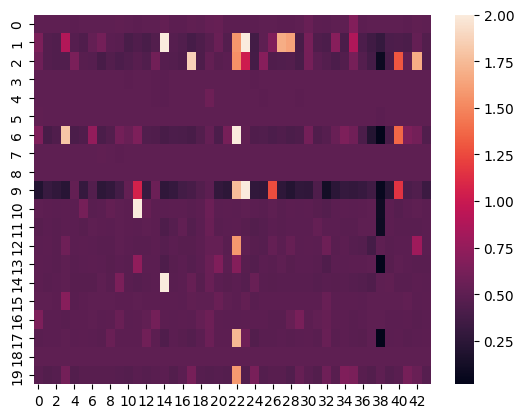

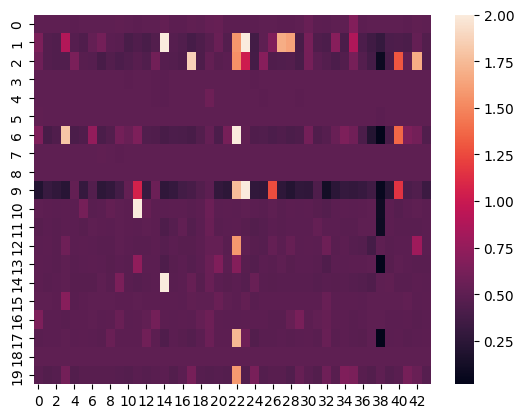

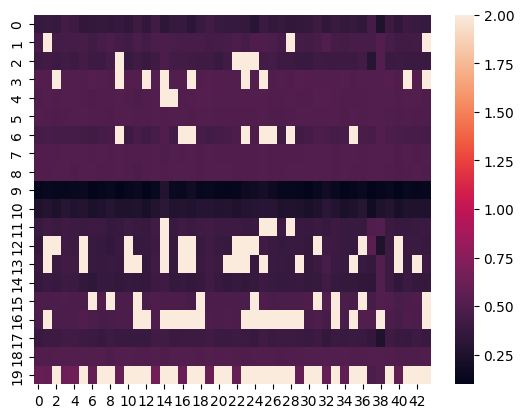

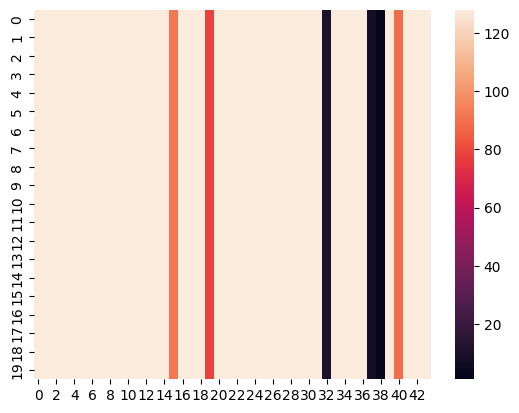

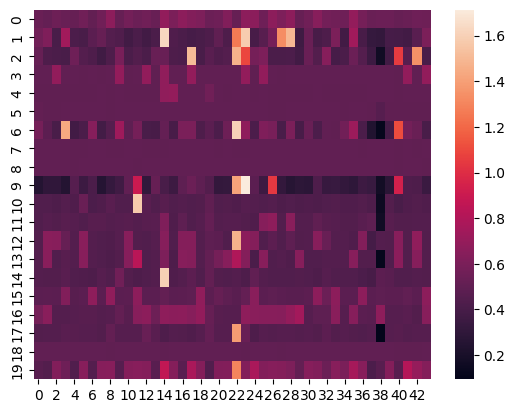

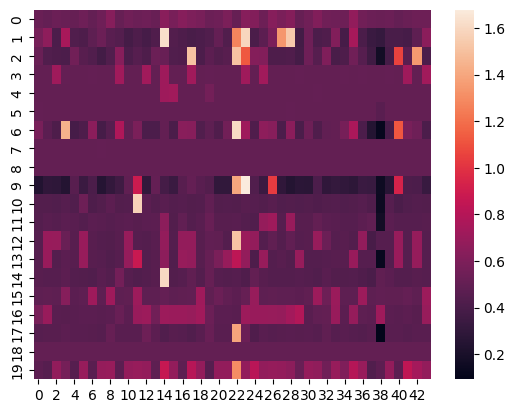

1


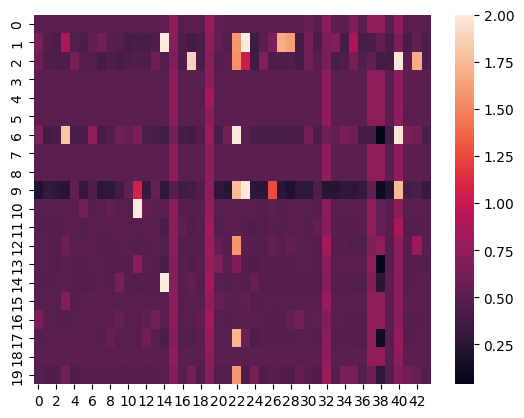

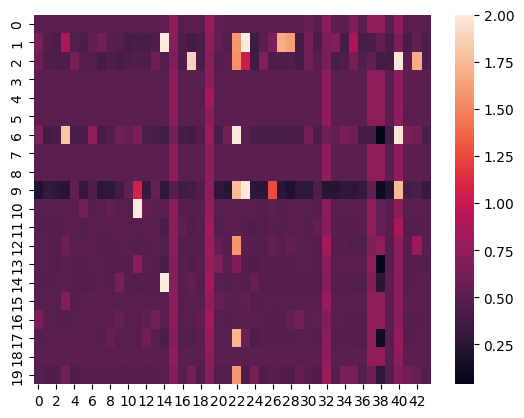

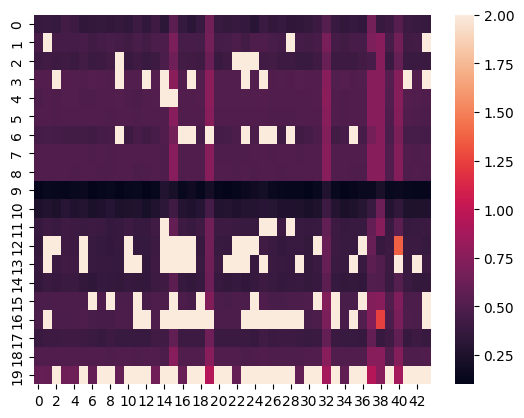

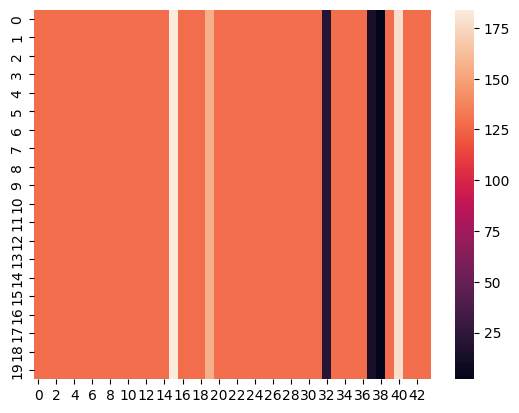

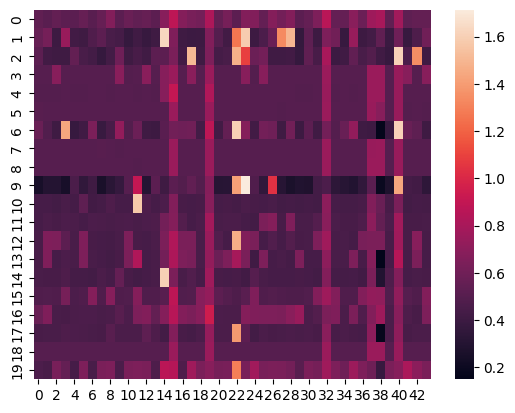

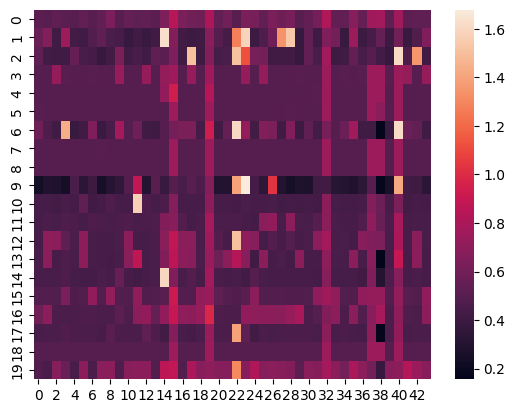

2


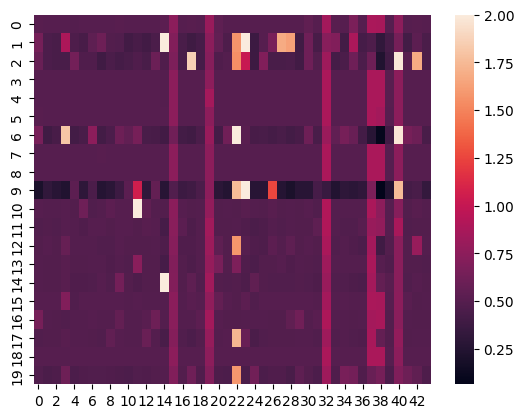

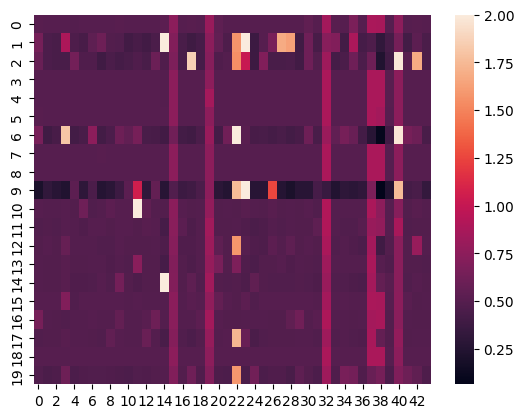

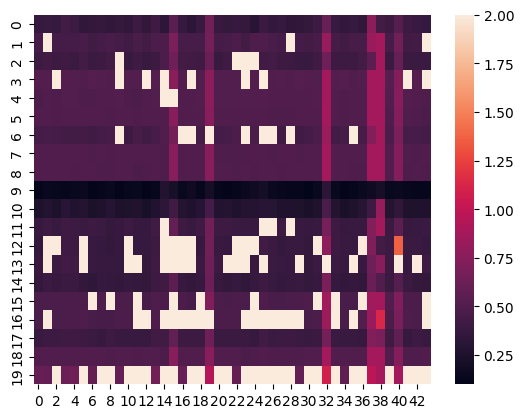

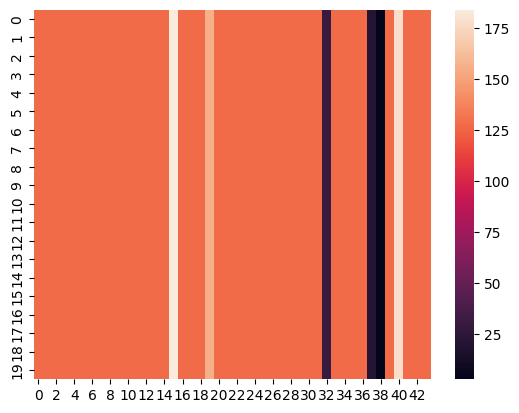

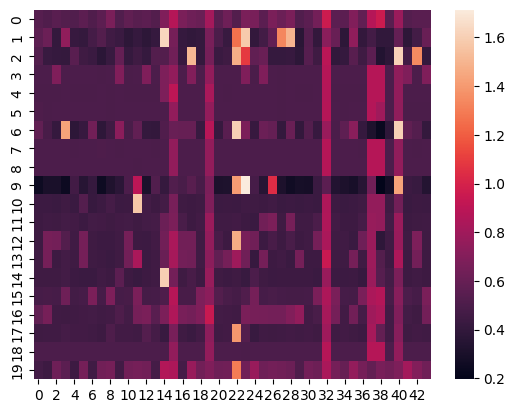

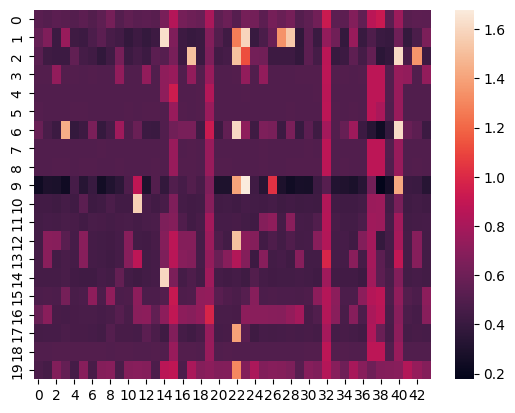

3


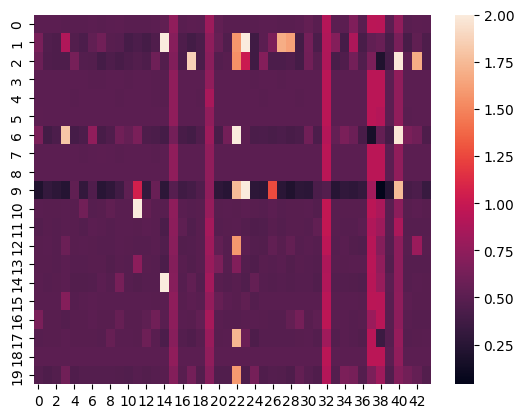

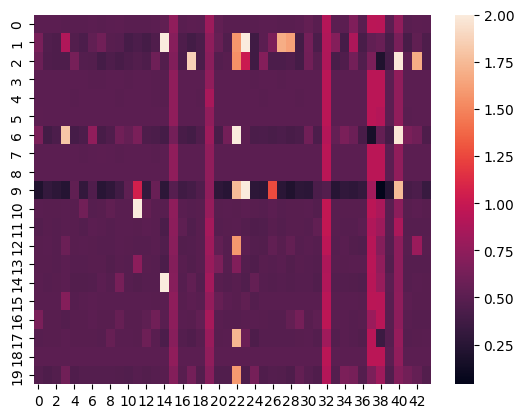

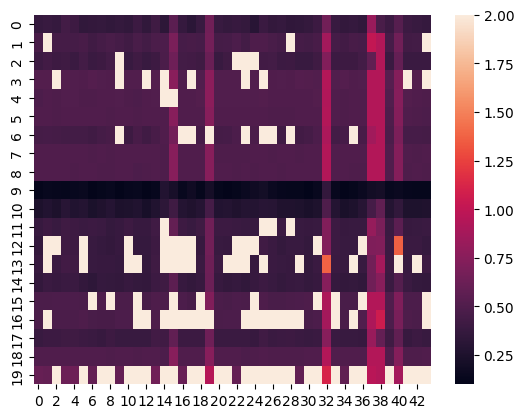

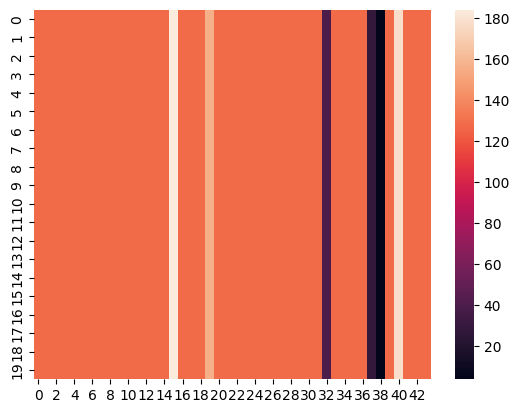

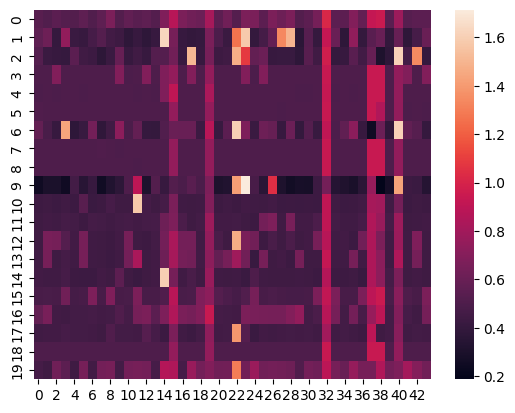

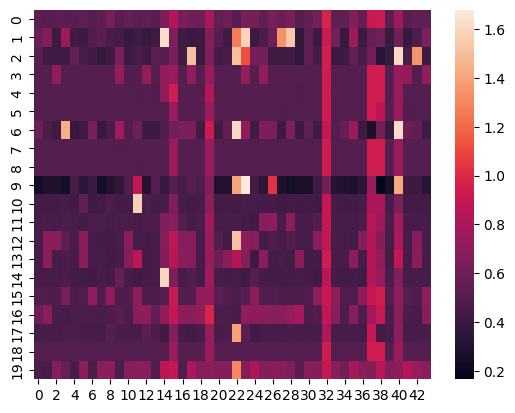

4


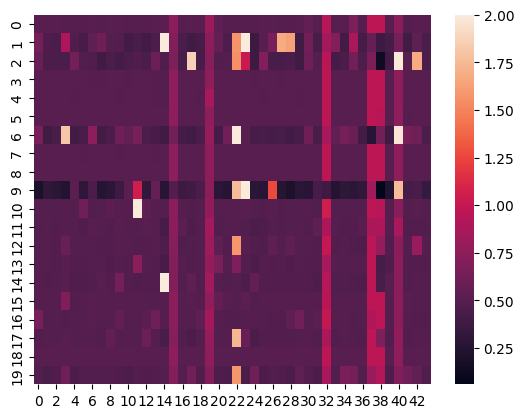

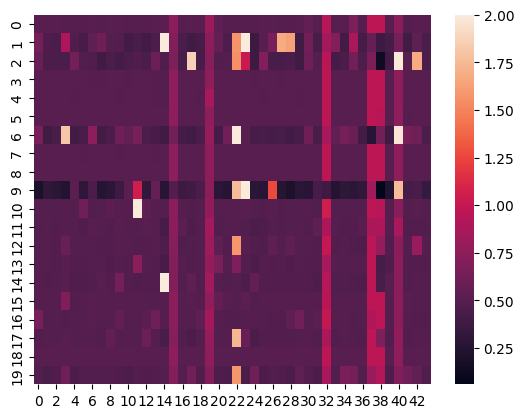

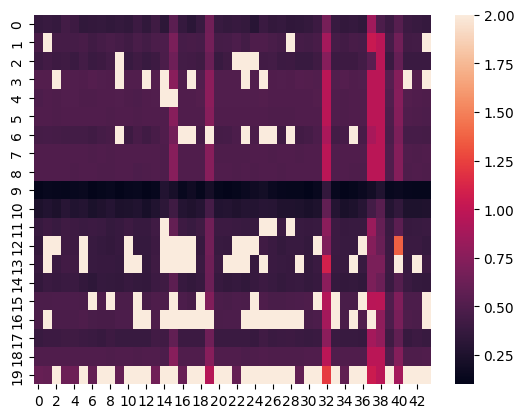

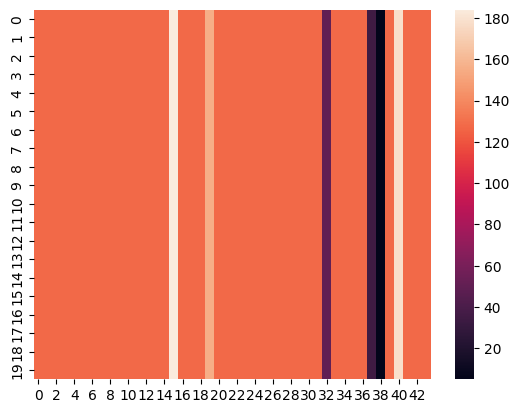

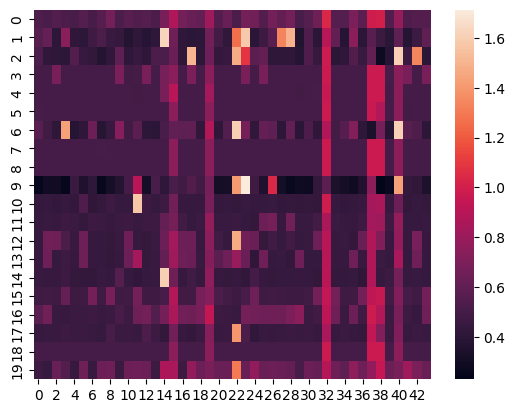

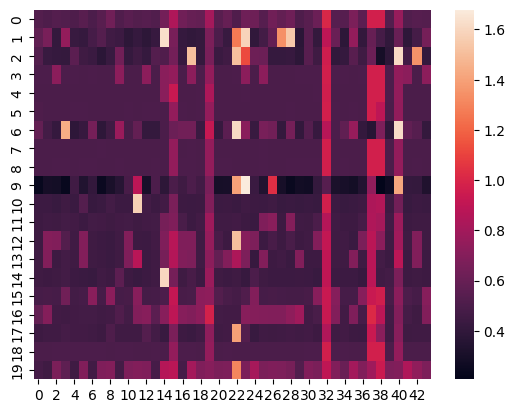

5


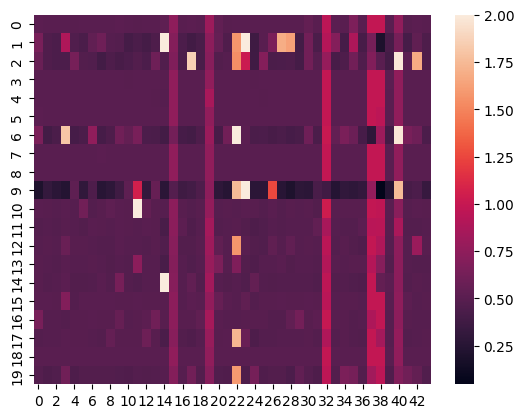

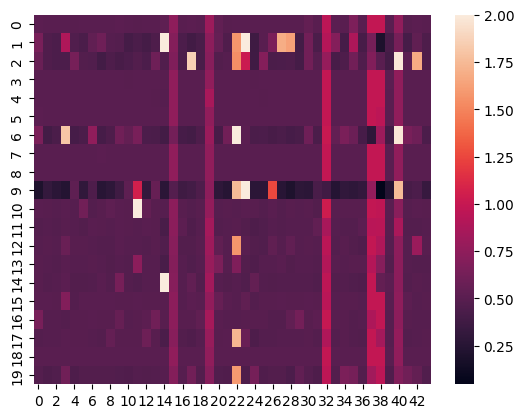

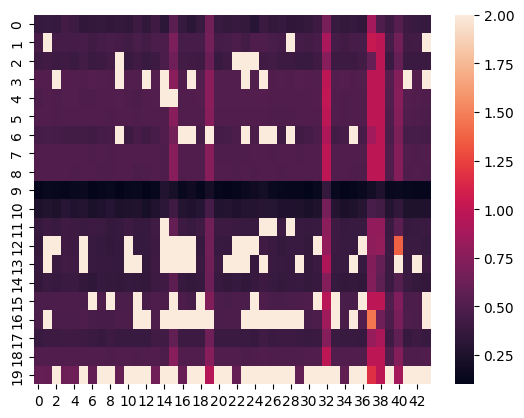

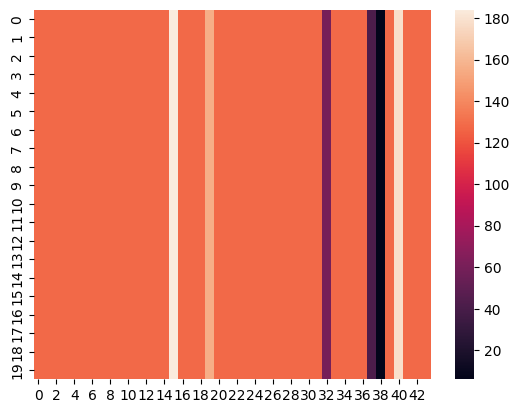

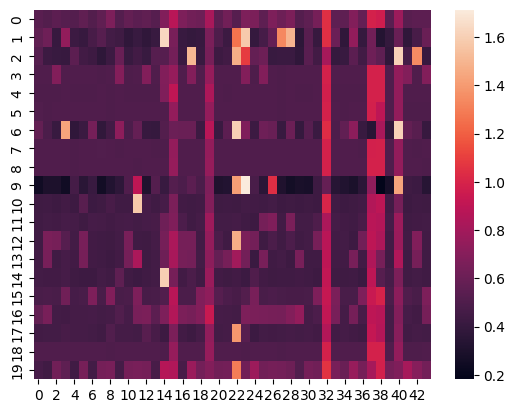

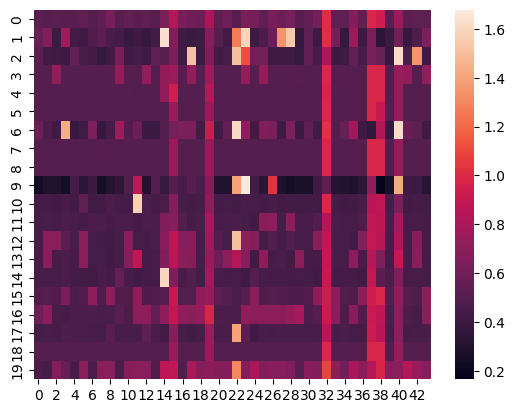

6


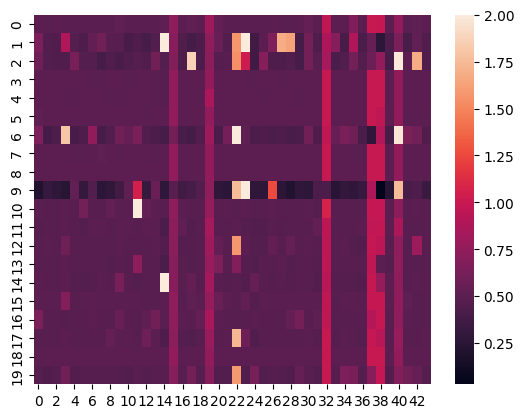

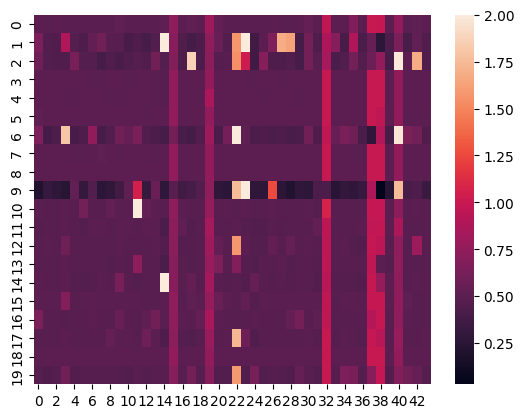

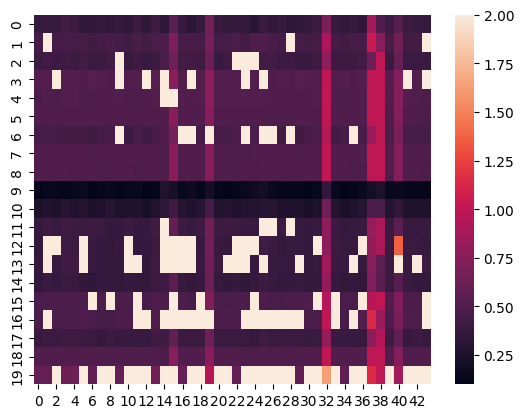

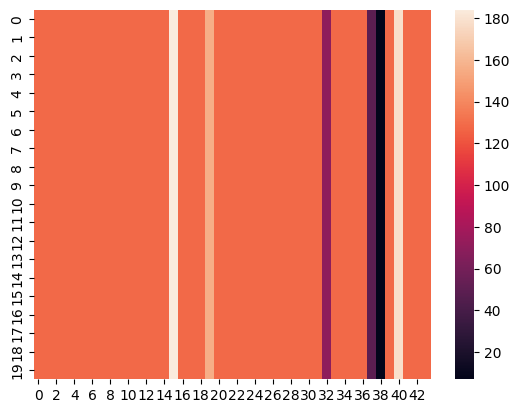

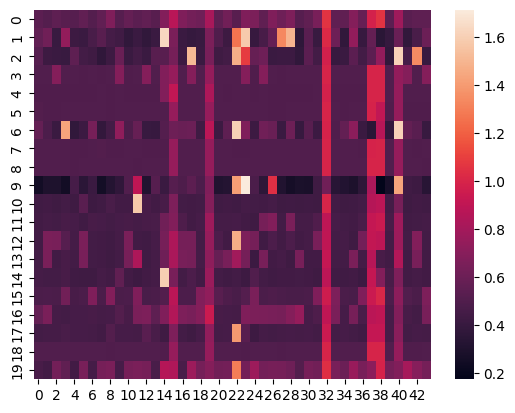

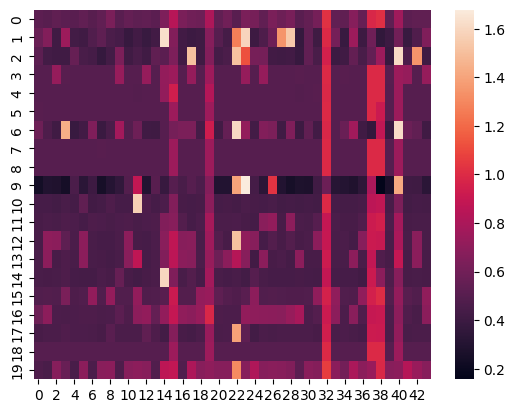

7


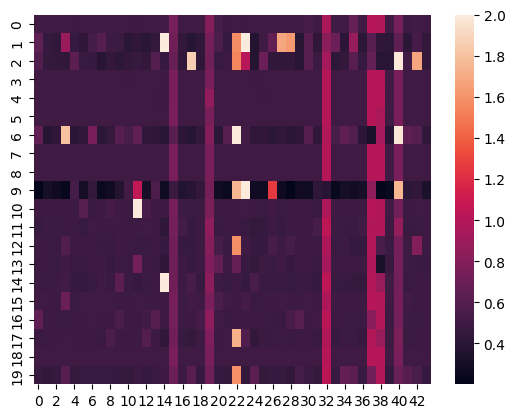

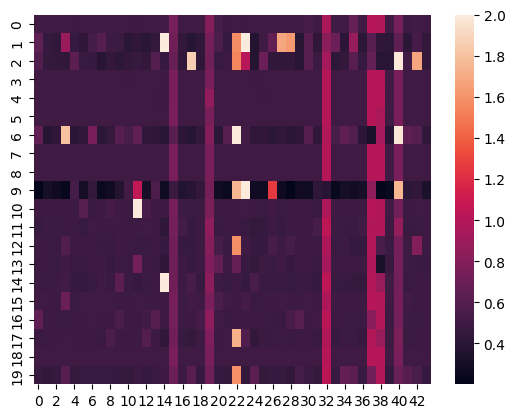

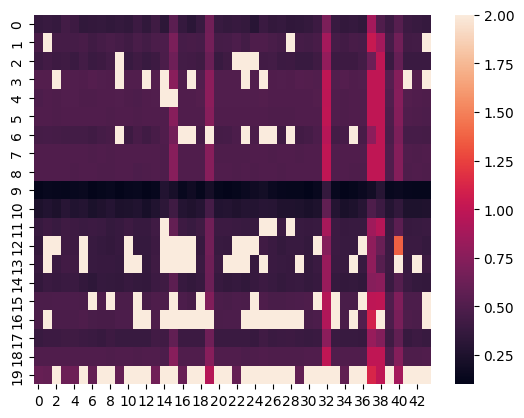

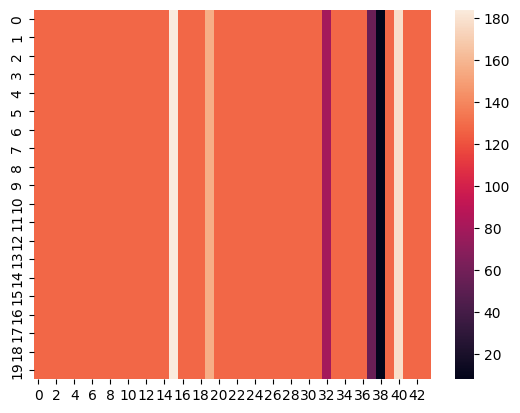

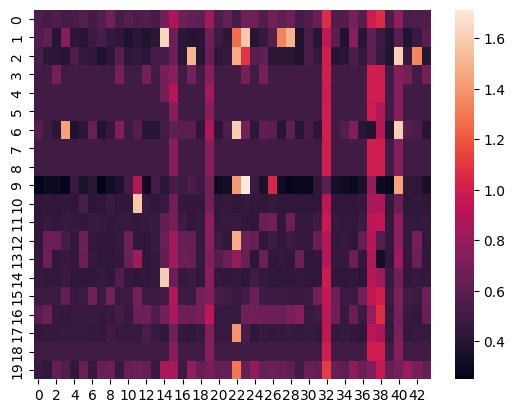

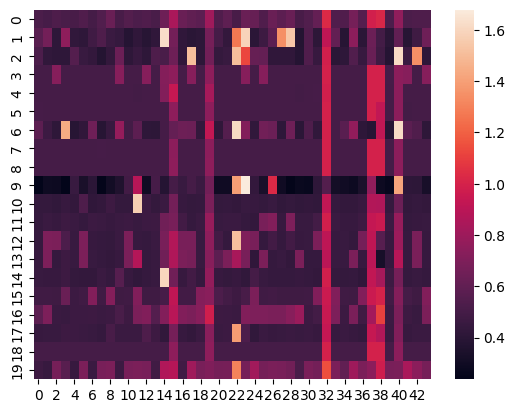

8


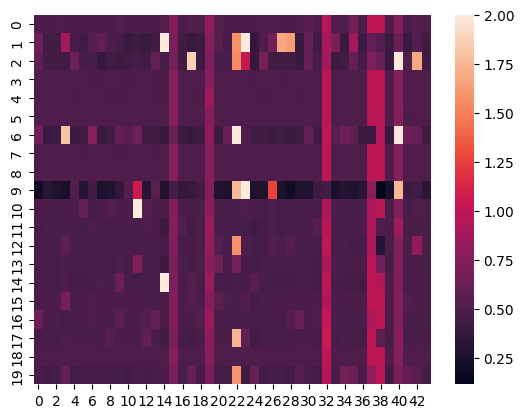

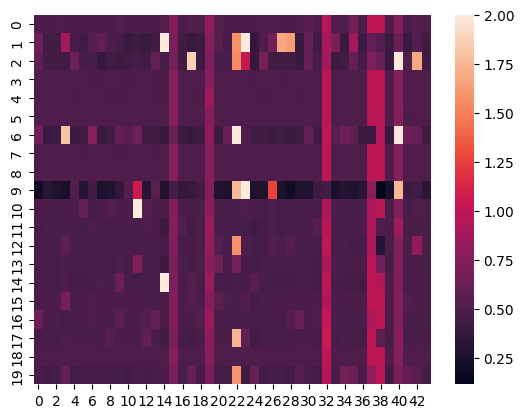

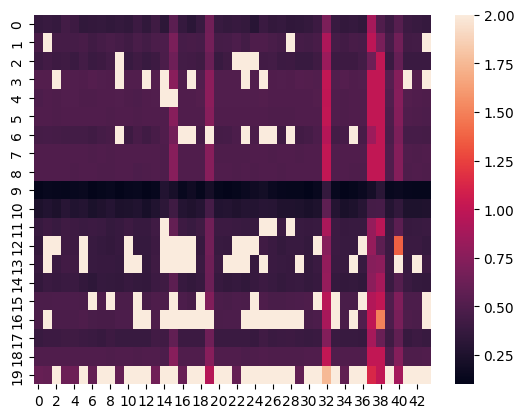

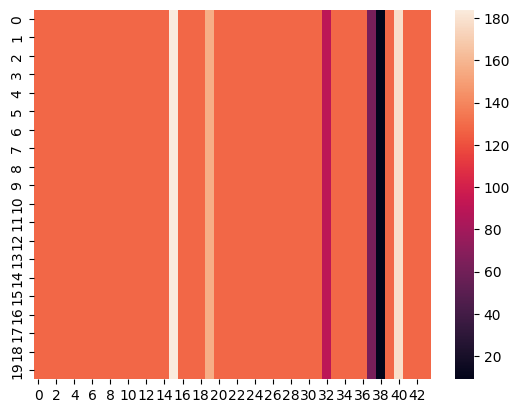

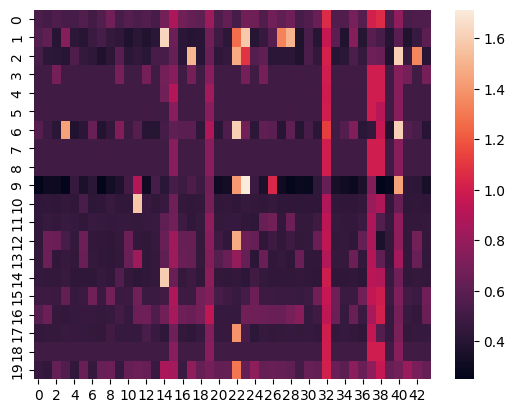

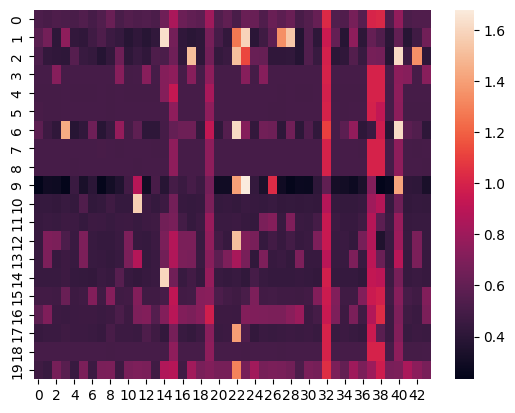

9


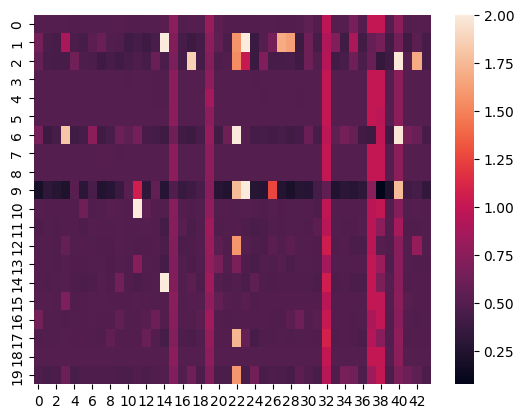

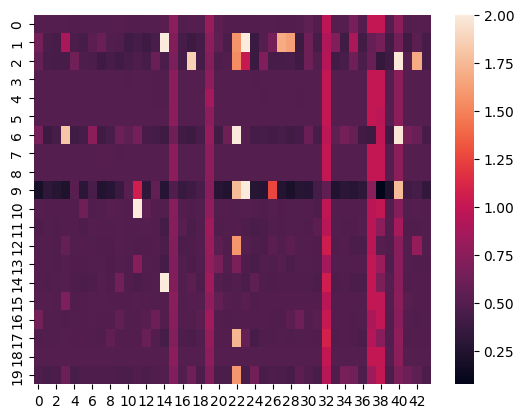

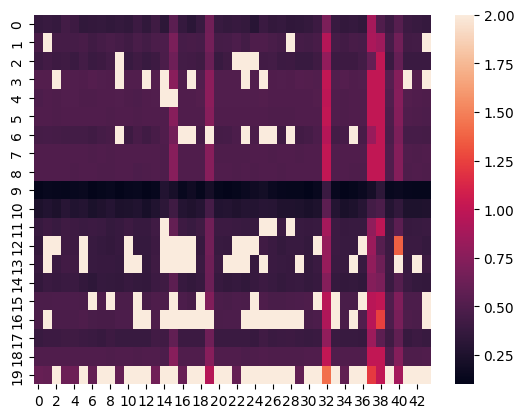

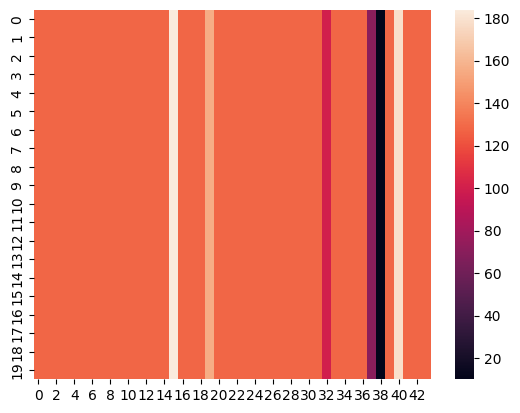

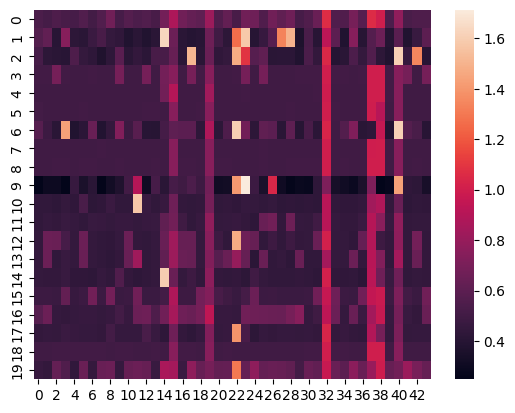

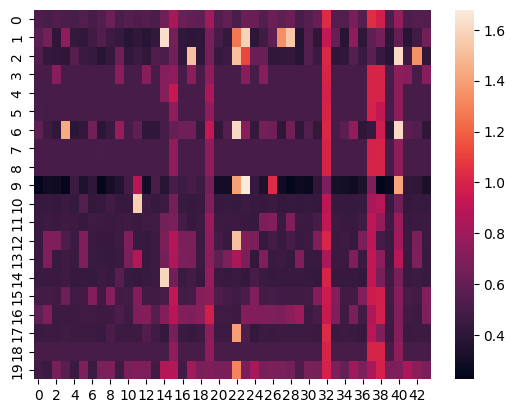

In [284]:
c_a, c_f, c_g = 0.75, 0.1, 0.15

for i in range(10):
    
    print(i)
    
    a = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.alignment-step-{i}.npy"))
    f = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.fluency-step-{i}.npy"))
    g = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.grammar-step-{i}.npy"))
    c = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.counts-step-{i}.npy"))
    t = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.tfim-step-{i}.npy"))
    
    sns.heatmap(a)
    plt.show()
    sns.heatmap(a)
    plt.show()
    sns.heatmap(g)
    plt.show()
    sns.heatmap(c)
    plt.show()
    sns.heatmap(t)
    plt.show()
    sns.heatmap((c_a * a) + (c_f * f) + (c_g * g))
    plt.show()
    
    print("=" * 80)

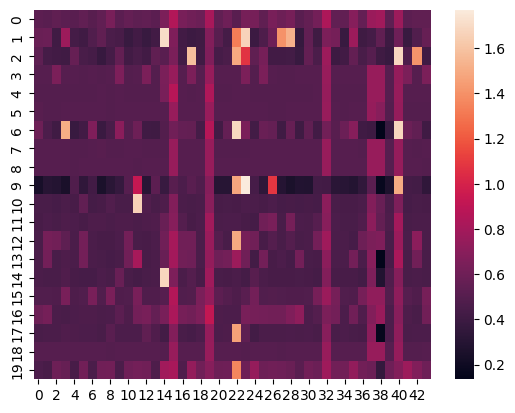

In [348]:
c_a, c_f, c_g = 0.8, 0.1, 0.1

TFIM = (c_a * a) + (c_f * f) + (c_g * g)

sns.heatmap(TFIM)

np.save("./eval/TFIM-ranking.npy", TFIM)

In [356]:
# 1. Augment dataset
feature_extractor = AMRFeatureExtractor()

dataset = load_dataset(*dataset_config, split="train").select(range(100))
dataset = dataset.rename_column("sentence", "text")

augmenter = Augmenter(
    dataset=dataset, 
    transforms=transforms, 
    transform_probabilities=None, 
    num_augmentations_per_record=1,
    num_transforms_to_apply = 1,
    keep_originals=False,
    feature_extractor=feature_extractor)
uni_dataset = augmenter.augment()

transforms_applied = np.array(uni_dataset["transforms_applied"], dtype=np.bool)
features = np.array(uni_dataset["features"], dtype=np.bool)

Found cached dataset glue (C:/Users/sleev/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
gid=x Start paren present but person is not a new concept
gid=x Start paren present but event is not a new concept
gid=x Start paren present but cause-01 is not a new concept


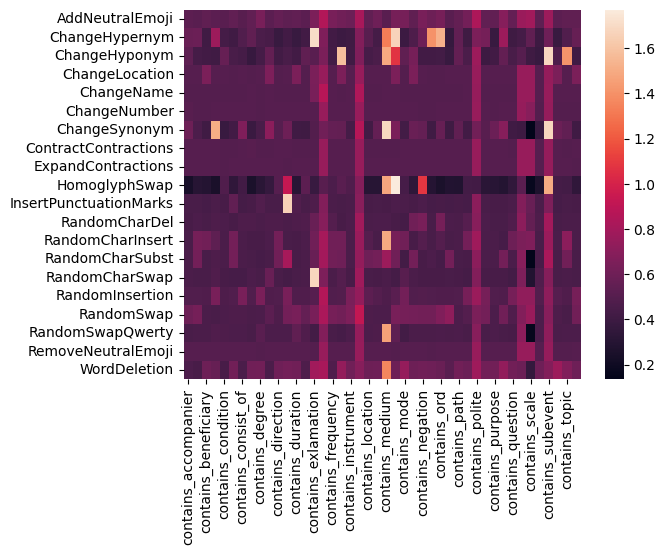

In [357]:
# 2. Load a TFIM
# tfim = np.load(sorted(glob.glob(f"./eval/fadata/sibyl/v2-*/*policy*"))[-1])
TFIM = np.load("./eval/TFIM-ranking.npy")
policy_heatmap(TFIM, transforms, feature_extractor.featurizers)

In [358]:
# 3-5. Query TFIM, aggregagate score, save to dataset
class TFIMQualityScorer:
    def __init__(self, tfim):
        self.tfim = tfim
        
    def score_record(self, transforms_applied, features):
        # type check
        if not isinstance(transforms_applied, np.ndarray):
            transforms_applied = np.array(transforms_applied, dtype=np.bool)
        if not isinstance(features, np.ndarray):
            features = np.array(features, dtype=np.bool)
        # empty check
        # if no transforms applied / features present, then average over all values
        if np.count_nonzero(features) == 0:
            features = np.full_like(features, fill_value=True)
        if np.count_nonzero(transforms_applied) == 0:
            transforms_applied = np.full_like(transforms_applied, fill_value=True)
        # query tfim
        return self.tfim[transforms_applied, features].mean()
    
    def score_dataset(self, dataset):
        scores = [self.score_record(r["transforms_applied"], r["features"]) for r in dataset]
        if "tfim_quality_score" in dataset.features:
            dataset= dataset.remove_columns(["tfim_quality_score"])
        dataset = dataset.add_column("tfim_quality_score", [s for s in scores])
        return dataset

In [359]:
def vectorize(output):
    sorted_output = sorted(output, key=lambda d: d['label']) 
    probs = np.array([d['score'] for d in sorted_output])
    return probs


class CleanLabQualityScorer:
    def __init__(self):
        self.api = HfApi()
        self.device = 0 if torch.cuda.is_available() else -1
        self.pipe = None

    def find_model_for_dataset(self, dataset_name):
        
        model_filter = ModelFilter(
            task="text-classification",
            library="pytorch",
            # model_name=dataset_name,
            trained_dataset=dataset_name)

        model_id = next(iter(self.api.list_models(filter=model_filter)))

        if model_id:
            model_id = getattr(model_id, 'modelId')
            print('Using ' + model_id + ' to support cleanlab datalabel issues.')
            self.pipe = pipeline("text-classification", 
                                 model=model_id, 
                                 device=self.device, 
                                 top_k=None)

    def extract_prediction_probabilities(self, dataset):
        if self.pipe is None:
            self.find_model_for_dataset(dataset.config_name)
        output = self.pipe(dataset['text'])
        return np.stack([vectorize(o) for o in output])

    def score_dataset(self, dataset):
        pred_probs = self.extract_prediction_probabilities(dataset)
        cleanlab_suss_score = get_label_quality_scores(
            labels=dataset['label'],
            pred_probs=pred_probs,  
        )
        if "cleanlab_quality_score" in dataset.features:
            dataset = dataset.remove_columns(["cleanlab_quality_score"])
        dataset = dataset.add_column("cleanlab_quality_score", [s for s in cleanlab_suss_score])
        return dataset

In [360]:
tfim_scorer = TFIMQualityScorer(TFIM)
uni_dataset = tfim_scorer.score_dataset(uni_dataset)

cl_scorer   = CleanLabQualityScorer()
uni_dataset = cl_scorer.score_dataset(uni_dataset)

uni_dataset

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.


Dataset({
    features: ['label', 'text', 'transforms_applied', 'is_changed', 'features', 'tfim_quality_score', 'cleanlab_quality_score'],
    num_rows: 100
})

In [361]:
df = uni_dataset.to_pandas()
df[["text", "label", "tfim_quality_score", "cleanlab_quality_score"]].sort_values("tfim_quality_score", ascending=False)

,text,label,tfim_quality_score,cleanlab_quality_score
9,are more deeply cerebrate through than in most...,1,1.664279,0.993186
74,"as a director , eastwood ! is off his game",0,0.851982,0.999629
91,aⅼternating bеtween facеtious comiϲ paⲅoԁy and...,1,0.697962,0.029296
38,oblivious to the existence of film,0,0.666431,0.999679
10,goes to absurd lengths,0,0.648637,0.999593
...,...,...,...,...
95,𝚏unny уet,1,0.409408,0.025726
58,deform with a fiction,1,0.394507,0.098470
3,be utterly satisfied to be the same throughout,0,0.382606,0.271095
87,"khouri manages , ԝi𝚝h terⲅіfіϲ 𝚏lair , tо keep...",1,0.338187,0.490899


c_a: 0.1, c_f: 0.45, c_g: 0.45


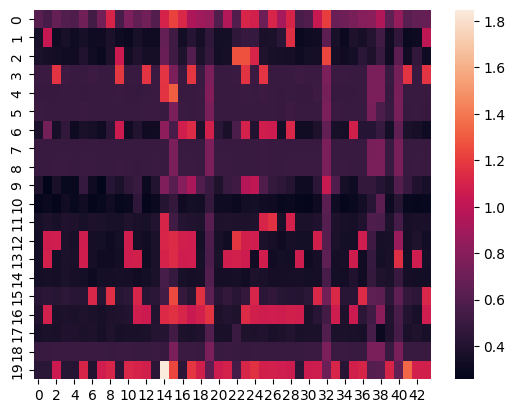

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.10718087929784802
c_a: 0.2, c_f: 0.4, c_g: 0.4


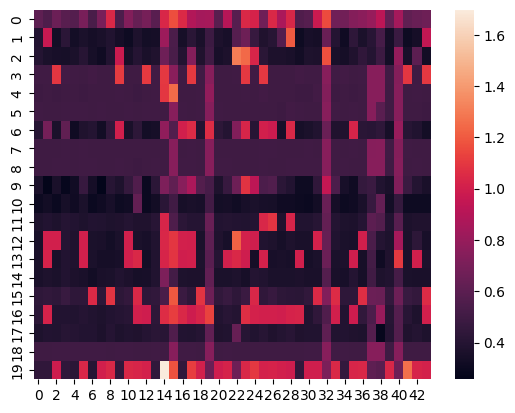

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.12077646002781814
c_a: 0.30000000000000004, c_f: 0.35, c_g: 0.35


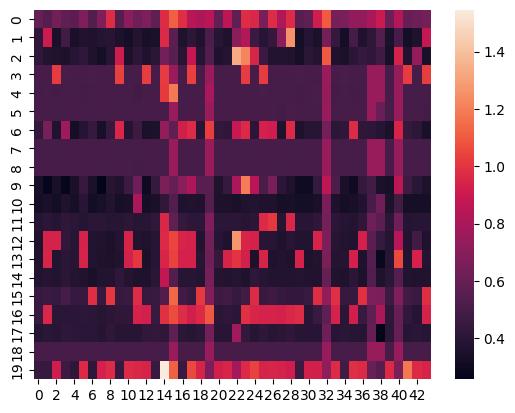

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.13665150729306652
c_a: 0.4, c_f: 0.3, c_g: 0.3


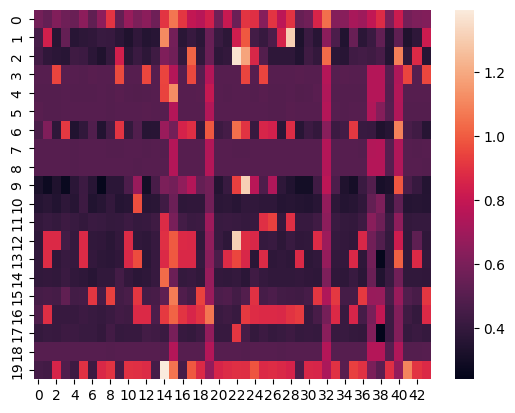

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.15409137295140804
c_a: 0.5, c_f: 0.25, c_g: 0.25


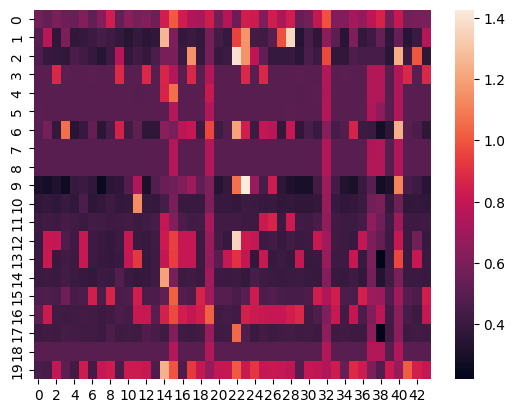

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.1706876380318209
c_a: 0.6, c_f: 0.2, c_g: 0.2


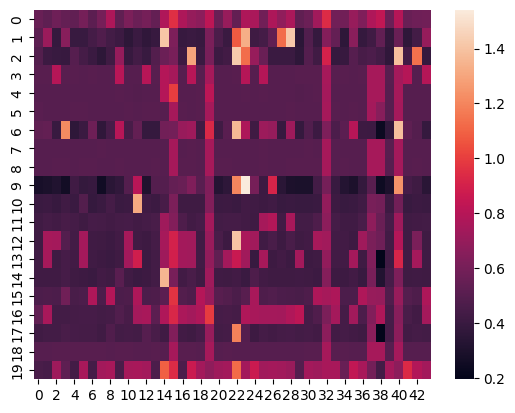

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.18180454037047897
c_a: 0.7000000000000001, c_f: 0.14999999999999997, c_g: 0.14999999999999997


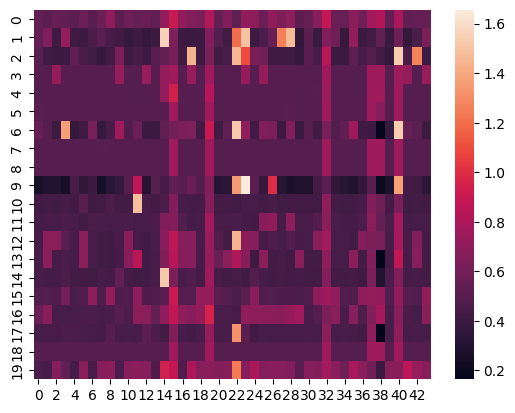

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.182610999290052
c_a: 0.8, c_f: 0.09999999999999998, c_g: 0.09999999999999998


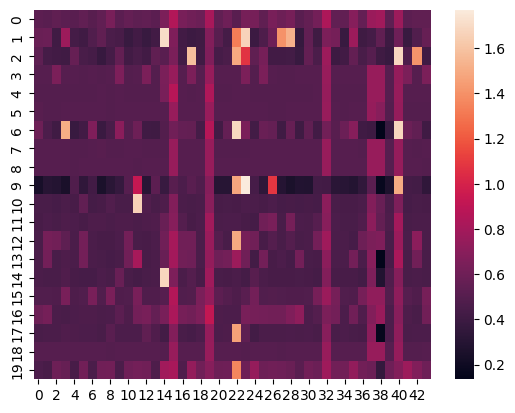

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.17250142141696356
c_a: 0.9, c_f: 0.04999999999999999, c_g: 0.04999999999999999


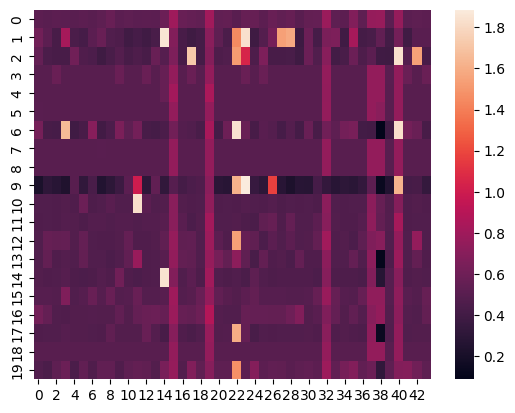

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.15580940917393665
c_a: 1.0, c_f: 0.0, c_g: 0.0


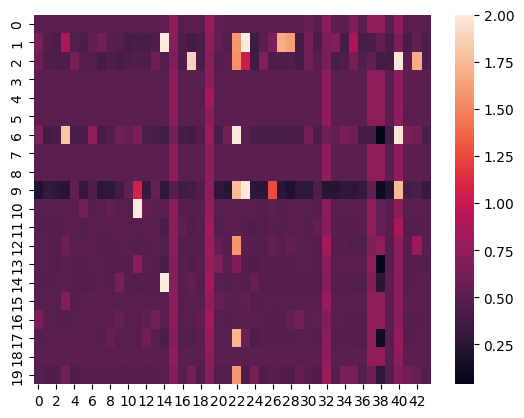

Using distilbert-base-uncased-finetuned-sst-2-english to support cleanlab datalabel issues.
correlation with cleanlab: 0.13757903266220242


In [362]:
for c_a in np.linspace(0.1, 1, 10):
    
    c_f = c_g = (1 - c_a) / 2
    
    print(f"c_a: {c_a}, c_f: {c_f}, c_g: {c_g}")
    
    i = 1
    
    a = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.alignment-step-{i}.npy"))
    f = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.fluency-step-{i}.npy"))
    g = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.grammar-step-{i}.npy"))
    c = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.counts-step-{i}.npy"))
    t = np.load(os.path.join(save_dir, f"glue.sst2.fada.v3.2.tfim-step-{i}.npy"))
    
    TFIM = (c_a * a) + (c_f * f) + (c_g * g)
    
    sns.heatmap(TFIM)
    plt.show()
    
    tfim_scorer = TFIMQualityScorer(TFIM)
    uni_dataset = tfim_scorer.score_dataset(uni_dataset)

    cl_scorer   = CleanLabQualityScorer()
    uni_dataset = cl_scorer.score_dataset(uni_dataset)

    df = uni_dataset.to_pandas()
    print(f"correlation with cleanlab: {df['tfim_quality_score'].corr(df['cleanlab_quality_score'])}")

In [ ]:
uni_dataset.to_pandas().to_csv("")